In [2]:
import os
import cv2
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Lambda
from tensorflow.keras.layers import concatenate, Dropout, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [4]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c data-science-bowl-2018

     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 4.2MB 32.4MB/s 
     |████████████████████████████████| 143kB 51.5MB/s 
     |████████████████████████████████| 112kB 55.4MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ujkaodic/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ujkaodic/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-fancjf82/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
{"username":"goubeast","key":"4ed2f19ecf2758bf5b587c7854acca88"}Warning: Looks like you're using an

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!mkdir Data
!cd Data
!mkdir Train
!mkdir Test

In [ ]:
#!unzip /content/stage1_train.zip -d /content/Data/Train
#!unzip /content/stage1_test.zip -d /content/Data/Test

In [11]:
np.random.seed(123)

img_width, img_height, img_channels = 128, 128, 3

train_path = '/content/Data/Train/'
test_path = '/content/Data/Test/'

In [12]:
train_id = next(os.walk(train_path))[1]
test_id = next(os.walk(test_path))[1]

x_train = np.zeros((len(train_id), img_width, img_height, img_channels), dtype=np.uint8)
y_train = np.zeros((len(train_id), img_width, img_height, 1), dtype=np.bool)

In [13]:
for n, id in tqdm(enumerate(train_id), total = len(train_id)):
  path = train_path + id
  img = imread(path + '/images/' + id + '.png')[:,:,:img_channels]
  img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
  x_train[n] = img
  mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
  for maskf in next(os.walk(path + '/masks/'))[2]:
    mask_ = imread(path + '/masks/' + maskf)
    mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode = 'constant',
                                  preserve_range = True), axis = -1)
    mask = np.maximum(mask, mask_)
  y_train[n] = mask

x_test = np.zeros((len(test_id), img_width, img_height, img_channels), dtype=np.uint8)
sizes_test = []
for n, id in tqdm(enumerate(test_id), total = len(test_id)):
  path = test_path + id
  img = imread(path + '/images/' + id + '.png')[:,:,:img_channels]
  sizes_test.append([img.shape[0], img.shape[1]])
  img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
  x_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 35.83it/s]


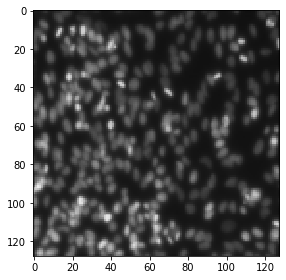

In [14]:
imageSample = random.randint(0, len(train_id))
imshow(x_train[imageSample])
plt.show()

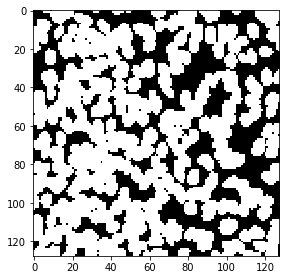

In [15]:
imshow(np.squeeze(y_train[imageSample]))
plt.show()

In [16]:
def UNet(shape):
    
    inputs = Input(shape = (shape))
    s = Lambda(lambda x : x / 255)(inputs)  
    
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)
    
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model = UNet((img_width, img_height, img_channels))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [18]:
checkpoint = ModelCheckpoint('nucleiModel.h5', verbose=1, save_best_only=True)

callbacks = [ EarlyStopping(patience = 3, monitor = 'val_loss'),
              TensorBoard(log_dir='logs')]

In [19]:
r = model.fit(x_train, y_train, validation_split = 0.1, batch_size = 16, epochs = 25,
              callbacks = callbacks)

Epoch 1/25
38/38 [==============================] - 11s 66ms/step - loss: 0.6125 - accuracy: 0.7948 - val_loss: 0.3725 - val_accuracy: 0.7955
Epoch 2/25
38/38 [==============================] - 1s 38ms/step - loss: 0.2899 - accuracy: 0.8438 - val_loss: 0.2107 - val_accuracy: 0.9276
Epoch 3/25
38/38 [==============================] - 1s 38ms/step - loss: 0.1733 - accuracy: 0.9373 - val_loss: 0.1869 - val_accuracy: 0.9337
Epoch 4/25
38/38 [==============================] - 1s 39ms/step - loss: 0.1299 - accuracy: 0.9553 - val_loss: 0.1523 - val_accuracy: 0.9440
Epoch 5/25
38/38 [==============================] - 1s 39ms/step - loss: 0.1265 - accuracy: 0.9542 - val_loss: 0.1478 - val_accuracy: 0.9474
Epoch 6/25
38/38 [==============================] - 1s 39ms/step - loss: 0.1215 - accuracy: 0.9548 - val_loss: 0.1280 - val_accuracy: 0.9507
Epoch 7/25
38/38 [==============================] - 1s 39ms/step - loss: 0.1003 - accuracy: 0.9619 - val_loss: 0.1406 - val_accuracy: 0.9489
Epoch 8/25
3

In [20]:
modeldir = os.path.join('/content/drive/My Drive/Datasets/', 'UNet_Nuclei.h5')
model.save(modeldir)

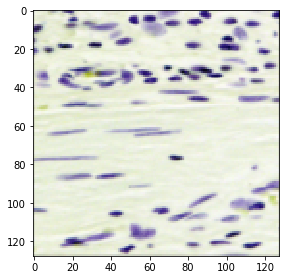

In [21]:
imageSample = random.randint(0, len(test_id))
imshow(x_test[imageSample])
plt.show()

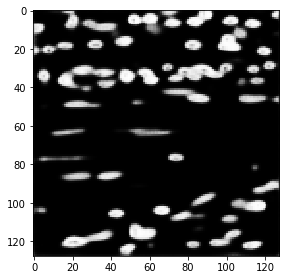

In [30]:
pred = model.predict(x_test[imageSample].reshape(1, 128, 128, 3))
imshow(pred.reshape(128, 128))
plt.show()